# Week 11 - Introduction to Modeling, part 2 

# 1. Lesson - No lesson this week 

# 2. Weekly graph question 

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer 

The book names one of Vonnegut's rules as "keep it simple" and another as "have the guts to cut."  Here is some data from the previous week's lesson.  If you had to cut one of the two plots below, which would it be?  Which seems more interesting or important?  Explain.  (Should "amount of training data used" or "number of estimators" be on the x-axis.) 

In [2]:
np.random.seed(0)
num_points = 10000
feature_1a = np.random.random(size = num_points) * 3
feature_2a = np.random.random(size = num_points) * 3
feature_3a = np.random.random(size = num_points) * 3
train_target = (feature_1a - 2 * feature_2a) * feature_3a + np.random.normal(size = num_points)
feature_1b = np.random.random(size = num_points) * 3
feature_2b = np.random.random(size = num_points) * 3
feature_3b = np.random.random(size = num_points) * 3
test_target = (feature_1b - 2 * feature_2b) * feature_3b + np.random.normal(size = num_points)
train_df = pd.DataFrame({"f1": feature_1a, "f2": feature_2a, "f3": feature_3a})
test_df = pd.DataFrame({"f1": feature_1b, "f2": feature_2b, "f3": feature_3b})
rf = RandomForestRegressor()
rf.fit(train_df.values, train_target) 

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [3]:
rmse_lst = list()
rf = RandomForestRegressor()
for x in range(round(num_points / 20), num_points, round(num_points / 20)):
    rf.fit(train_df.values[0:x,:], train_target[0:x])
    rmse_lst.append(root_mean_squared_error(rf.predict(test_df.values), test_target))

import matplotlib.pyplot as plt 

Text(0, 0.5, 'Loss function')

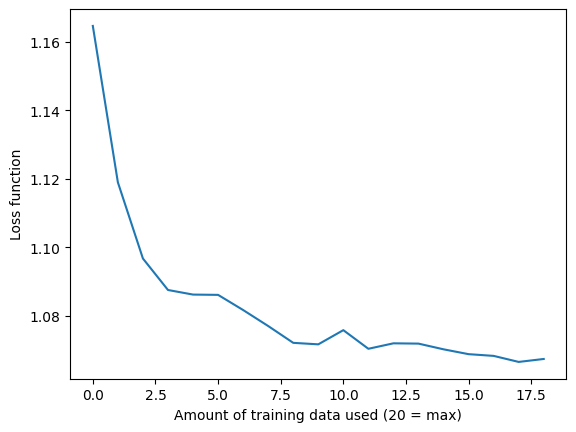

In [4]:
plt.plot(rmse_lst)
plt.xlabel("Amount of training data used (20 = max)")
plt.ylabel("Loss function")

In [5]:
num_trees_lst = list()
for n_estimators in range(1, 100, 3):
    rf = RandomForestRegressor(n_estimators = n_estimators)
    rf.fit(train_df.values, train_target)
    num_trees_lst.append(root_mean_squared_error(rf.predict(test_df.values), test_target)) 

Text(0, 0.5, 'Loss function')

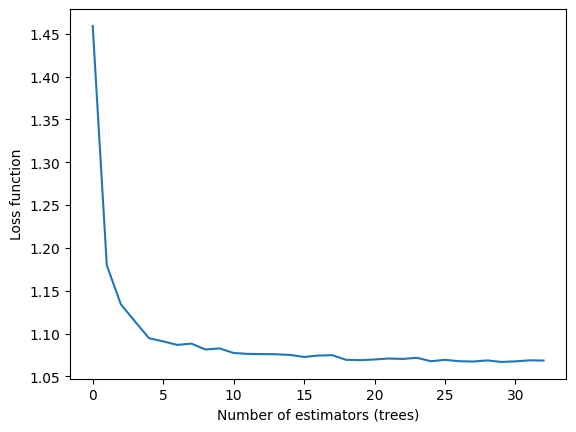

In [6]:
plt.plot(num_trees_lst)
plt.xlabel("Number of estimators (trees)")
plt.ylabel("Loss function") 

# 3. Working on your datasets 

This week, you will do the same types of exercises as last week, but you should use your chosen datasets that someone in your class found last semester. (They likely will not be the particular datasets that you found yourself.)

Here are some types of analysis you can do:

* Implement a random forest model.
* Perform cross-validation.
* Tune hyperparameters.
* Evaluate a performance metric.

If you like, you can try other types of models, too (beyond linear regression and random forest) although you will have many opportunities to do that next semester.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv("diabetes_012_health_indicators_BRFSS2015.csv")
X = df.drop(columns=["Diabetes_012"])

y = df["Diabetes_012"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
) 



In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

clf = RandomForestClassifier(random_state=42)

cv_acc = cross_val_score(clf, X_train, y_train, cv=5, scoring="accuracy", n_jobs=-1)
print(f"CV accuracy: {cv_acc.mean():.3f} ± {cv_acc.std():.3f}") 

CV accuracy: 0.842 ± 0.001


In [17]:
from sklearn.model_selection import cross_validate

scoring = ["accuracy", "precision_macro", "recall_macro", "f1_macro", "roc_auc_ovr"]
results = cross_validate(
    clf, X_train, y_train,
    cv=5,
    scoring=scoring,
    return_train_score=False,
    n_jobs=-1
)

for m in scoring:
    test_scores = results[f"test_{m}"]
    print(f"{m:<12}: {test_scores.mean():.3f} ± {test_scores.std():.3f}")

accuracy    : 0.842 ± 0.001
precision_macro: 0.457 ± 0.011
recall_macro: 0.388 ± 0.003
f1_macro    : 0.398 ± 0.003
roc_auc_ovr : 0.738 ± 0.001


In [18]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_dist = {
    "n_estimators": randint(50, 200),
    "max_depth": randint(3, 20),
    "min_samples_leaf": randint(1, 5),
}

rs = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=25,
    cv=5,
    scoring="accuracy",
    random_state=0,
    n_jobs=-1,
    refit=True
)
rs.fit(X_train, y_train)

print("Best params:", rs.best_params_)
print("Best CV accuracy:", round(rs.best_score_, 3))

Best params: {'max_depth': 15, 'min_samples_leaf': 3, 'n_estimators': 89}
Best CV accuracy: 0.85


In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

y_pred = rs.predict(X_test)
y_proba = rs.predict_proba(X_test)

print(f"Test accuracy           : {round(accuracy_score(y_test, y_pred), 3)}")
print(f"Test precision (macro)  : {round(precision_score(y_test, y_pred, average='macro'), 3)}")
print(f"Test recall (macro)     : {round(recall_score(y_test, y_pred, average='macro'), 3)}")
print(f"Test F1‑score (macro)   : {round(f1_score(y_test, y_pred, average='macro'), 3)}")

if y.nunique() > 2:
    auc = roc_auc_score(y_test, y_proba, multi_class="ovr", average="macro")
else:
    auc = roc_auc_score(y_test, y_proba[:, 1])
print(f"Test ROC AUC (ovr)      : {round(auc, 3)}") 

Test accuracy           : 0.849
Test precision (macro)  : 0.479
Test recall (macro)     : 0.375
Test F1‑score (macro)   : 0.382
Test ROC AUC (ovr)      : 0.781


/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


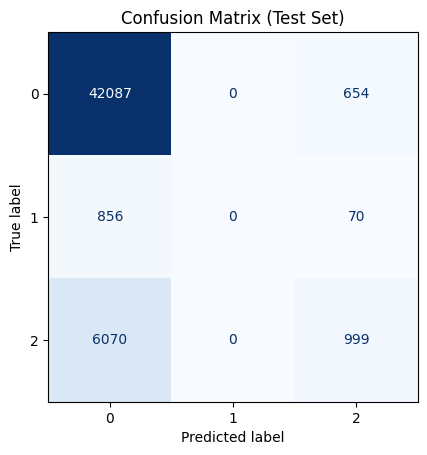

In [20]:
cm = confusion_matrix(y_test, y_pred, labels=rs.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rs.classes_)
disp.plot(cmap="Blues", colorbar=False)
plt.title("Confusion Matrix (Test Set)")
plt.show() 

# 4. Storytelling With Data plot 

Reproduce any graph of your choice in chapter seven (p. 165-185) of the Storytelling With Data book as best you can. You do not have to get the exact data values right, just the overall look and feel.

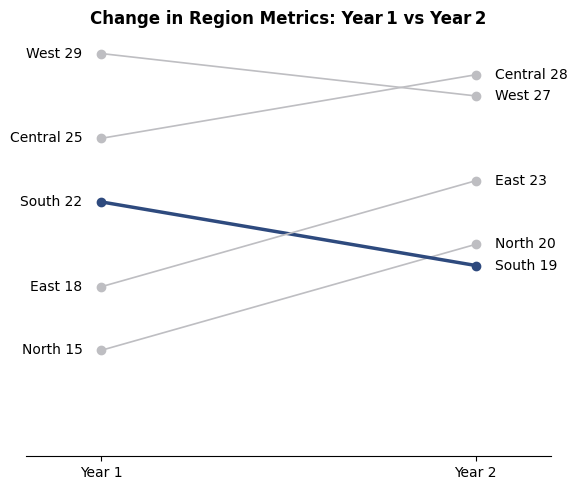

In [21]:
import matplotlib.pyplot as plt
import pandas as pd

data = {
    'Region': ['North', 'South', 'East', 'West', 'Central'],
    'Year1': [15, 22, 18, 29, 25],
    'Year2': [20, 19, 23, 27, 28]
}
df = pd.DataFrame(data)

plt.figure(figsize=(6, 5))
for _, row in df.iterrows():
    x = [0, 1]
    y = [row['Year1'], row['Year2']]
    color = '#2E4A7E' if row['Region']=='South' else '#BEBEC2'
    lw = 2.5 if row['Region']=='South' else 1.2
    plt.plot(x, y, marker='o', color=color, linewidth=lw)
    plt.text(x[0]-0.05, y[0], f"{row['Region']} {y[0]}", ha='right', va='center')
    plt.text(x[1]+0.05, y[1], f"{row['Region']} {y[1]}", ha='left', va='center')

plt.xticks([0, 1], ['Year 1', 'Year 2'])
plt.xlim(-0.2, 1.2)
plt.ylim(10, 30)
plt.title('Change in Region Metrics: Year 1 vs Year 2', fontsize=12, fontweight='bold')
# Style: no y-axis labels, minimal ticks
plt.gca().axes.get_yaxis().set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.tight_layout()
plt.show()